[View in Colaboratory](https://colab.research.google.com/github/connected-bsamadi/colab-notebooks/blob/master/Package_Recommendation_Engine_RNN.ipynb)

# Setting up

In [0]:
# Google Cloud authentication
from google.colab import auth
auth.authenticate_user()

In [0]:
# Installing packages
!pip install nltk > /dev/null
!pip install rake-nltk > /dev/null
!pip install just > /dev/null


In [0]:
# Download a list of stop words for RAKE
!wget https://raw.githubusercontent.com/zelandiya/RAKE-tutorial/master/data/stoplists/SmartStoplist.txt > /dev/null


Redirecting output to ‘wget-log.6’.


In [0]:
from google.cloud import bigquery
import json
import re
import pandas
from rake_nltk import Rake
import sys
import just
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [0]:
# Assigning the project name and creating the BigQuery client
# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'ontario-2018'
client = bigquery.Client(project=project_id)

# Data Query
BigQuery is used to get the data from the github_repos dataset.

In [0]:
# Legacy SQL is used
job_config = bigquery.job.QueryJobConfig()
job_config.use_legacy_sql=True

## Extracting packages

In [0]:
### Get packages from big query
query = ('''
SELECT sample_repo_name, content
FROM [bigquery-public-data:github_repos.sample_contents] contents
INNER JOIN [bigquery-public-data:github_repos.sample_files] files
  ON contents.id = files.id
INNER JOIN [bigquery-public-data:github_repos.sample_repos] repos
  ON contents.sample_repo_name = repos.repo_name
WHERE files.path = 'package.json' AND repos.watch_count > 1000
''')
query_job = client.query(query,job_config)
package_results = query_job.to_dataframe().values

In [0]:
### Transform package_results into package_array
package_array = []
package_reponame_array = []
for package in package_results:
    repo_obj = json.loads(package[1])
    package_record = {}
    package_record["reponame"] = package[0]
    package_reponame_array.append(package[0])
    if "name" in repo_obj:
      package_record["name"] = repo_obj["name"]
    if "devDependencies" in repo_obj:
      dev_dependencies = repo_obj["devDependencies"]
      if (len(dev_dependencies) > 0):
        package_record["devDependencies"] = dev_dependencies
    if "dependencies" in repo_obj:
      dependencies = repo_obj["dependencies"]
      if (len(dependencies) > 0):
        package_record["dependencies"] = dependencies
    if "keywords" in repo_obj:
      keywords = repo_obj["keywords"]
      if (len(keywords) > 0):
        package_record["keywords"] = keywords
    package_array.append(package_record)

## Extracting Readme Files

In [0]:
### Get README.md files from big query

job_config = bigquery.job.QueryJobConfig()
job_config.use_legacy_sql=False
query = ('''SELECT files.repo_name, content
FROM `bigquery-public-data.github_repos.contents` contents
INNER JOIN `bigquery-public-data.github_repos.files` files
  ON contents.id = files.id
WHERE files.path IN ('readme.md','Readme.md', 'README.md', 'README.MD') AND files.repo_name IN UNNEST(@repolist)
''')

query_params = [
    bigquery.ArrayQueryParameter('repolist', 'STRING', package_reponame_array)
]
job_config.query_parameters = query_params
query_job = client.query(query,job_config)
readme_results = query_job.to_dataframe().values
print(len(package_reponame_array))
print(len(readme_results))

25
22


In [0]:
### Transform readme_results into readme_array

readme_array = []
for readme_interim in readme_results:
  readme_record = {}
  readme_record["reponame"] = readme_interim[0]
  readme_record["content"] = readme_interim[1]
  readme_array.append(readme_record)

# Creating training data

In [0]:
### Load the content of SmartStoplist.txt into stop_words

stop_words=[]
with open("SmartStoplist.txt", 'r') as f:
    for i, x in enumerate(f):
        if 1 <= i:
            stop_words.append(x.rstrip())

In [0]:
### Extract keywords using Rake

rake = Rake(stopwords=stop_words, max_length=1)
concatenated_readme = ''
for readme in readme_array:
  concatenated_readme = concatenated_readme + readme["content"]
rake.extract_keywords_from_text(concatenated_readme)
ranked_phrases = rake.get_ranked_phrases()

In [0]:
### Remove all non-english characters

pattern = re.compile("[a-zA-Z0-9]")
input_nodes = list(filter(lambda x: bool(re.match(pattern, x)), ranked_phrases))
input_nodes = list(filter(lambda x: len(x)>1, input_nodes))
print(input_nodes)
len(input_nodes)

['zos', 'zip', 'zh_cn', 'zfy6ll7efa', 'zenparsing', 'zen', 'youtube', 'youtu', 'yielded', 'yieldables', 'yieldable', 'yield', 'yelouafi', 'yellowgreen', 'yellowapple', 'yellow', 'years', 'yarn', 'yandex', 'xojs', 'xo', 'xmlhttprequest', 'xcodeproj', 'xcode', 'wrong', 'written', 'writing', 'write', 'wrap', 'wpo', 'wow', 'worry', 'world', 'works', 'working', 'workarounds', 'workaround', 'work', 'won', 'withgoogle', 'windowscroller', 'windows', 'windowing', 'window', 'win', 'wikipedia', 'wiki', 'width', 'white', 'whatwg', 'weststrate', 'welcoming', 'weeks', 'webstorm', 'webstore', 'website', 'websemantics', 'webscr', 'webpagetest', 'webpack', 'web', 'wearejh', 'ways', 'watches', 'watch', 'wasn', 'warranty', 'warranties', 'warnings', 'warning', 'warn', 'wait', 'vue', 'vscode', 'voted', 'vortex', 'voorhoede', 'voila', 'visualization', 'visiting', 'visit', 'visionmedia', 'virtualized', 'virtualization', 'viewport', 'viewmodel', 'viewer', 'view', 'videos', 'vi', 'versions', 'version', 'verify

2483

In [0]:
### Perform keyword extraction for individual reademe files and
### remove keywords that are not in the target input_nodes
readme_keywords_array = []
for readme_entry in readme_array:
  raked_entry = rake.extract_keywords_from_text(readme_entry["content"])
  ranked_phrases = rake.get_ranked_phrases()
  # Filter keywords
  ranked_phrases = list(filter(lambda x: x in input_nodes,ranked_phrases))
  # Build keywords object
  keywords = {}
  keywords["reponame"] = readme_entry["reponame"]
  keywords["keywords"] = ranked_phrases
  readme_keywords_array.append(keywords)

In [0]:
# Creating a dictionary for keywords
repos = []
keywords_dic={}
for i in range(len(readme_keywords_array)):
  repos.append(readme_keywords_array[i]["reponame"])
  keywords_dic[readme_keywords_array[i]["reponame"]] = readme_keywords_array[i]["keywords"]
len(repos)

22

In [0]:
# Creating a dictionary for packages
packages_dic={}
for repo in package_array:
  if repo["reponame"] in repos:
    packages_dic[repo["reponame"]] = []
    if "devDependencies" in repo:
      packages_dic[repo["reponame"]].append(repo["devDependencies"])
    if "dependencies" in repo:
      packages_dic[repo["reponame"]].append(repo["dependencies"])
len(packages_dic.keys())

22

# Training Data

In [0]:
# list keywords for each repo
Questions = [keywords_dic[i] for i in repos]
max_input_len = max(map(len, Questions))

# list of unique keywords
input_tokens = list({keyword for repo_list in Questions for keyword in repo_list})
num_input_tokens = len(input_tokens)
keyword_to_index = {}
for i in range(len(input_tokens)):
  keyword_to_index[input_tokens[i]]=i
index_to_keyword = {v: k for k, v in keyword_to_index.items()}

In [0]:
# list packages for each repo
Answers = [list(packages_dic[i][0]) for i in repos]
max_output_len = max(map(len, Answers))

# list of unique packages
output_tokens = list({pkg for repo_pkg in Answers for pkg in repo_pkg})
num_output_tokens = len(output_tokens)
package_to_index = {}
for i in range(len(output_tokens)):
  package_to_index[output_tokens[i]]=i
index_to_package = {v: k for k, v in package_to_index.items()}

In [0]:
n = len(repos)
X = np.zeros((n, max_input_len, num_input_tokens), dtype=np.bool)
y = np.zeros((n, num_output_tokens), dtype=np.bool)
for num_pair, (question, answer) in enumerate(zip(Questions, Answers)):
  for num_token, q_token in enumerate(question):
    X[num_pair, num_token, keyword_to_index[q_token]] = 1
  for num_token, a_token in enumerate(answer):
    y[num_pair, package_to_index[a_token]] = 1

# Build the model

In [0]:
hidden_units=128
model = Sequential()
input_s = (None, num_input_tokens)
model.add(LSTM(hidden_units, input_shape=input_s))
model.add(Dense(num_output_tokens))
model.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

# Training

In [0]:
iterations=20
bat_size=256
num_epochs=3
for iteration in range(iterations):
  print()
  print('-' * 50)
  print('Iteration', iteration)
  model.fit(X, y, batch_size=bat_size, epochs=num_epochs)


--------------------------------------------------
Iteration 0
Epoch 1/3
22/22 [==============================] - 5s 217ms/step - loss: 99.4402
Epoch 2/3
22/22 [==============================] - 4s 178ms/step - loss: 132.6980
Epoch 3/3
22/22 [==============================] - 4s 168ms/step - loss: 99.2543

--------------------------------------------------
Iteration 1
Epoch 1/3
22/22 [==============================] - 4s 165ms/step - loss: 99.7557
Epoch 2/3
22/22 [==============================] - 4s 168ms/step - loss: 97.0515
Epoch 3/3
22/22 [==============================] - 4s 163ms/step - loss: 97.0115

--------------------------------------------------
Iteration 2
Epoch 1/3
22/22 [==============================] - 4s 162ms/step - loss: 97.5773
Epoch 2/3
22/22 [==============================] - 4s 162ms/step - loss: 99.6110
Epoch 3/3
22/22 [==============================] - 4s 164ms/step - loss: 103.7948

--------------------------------------------------
Iteration 3
Epoch 1/3
22/

In [0]:
model.save("neural_token")

# Prediction

In [0]:
repo=repos[1]
keys = keywords_dic[repo]
keys_encoded = np.zeros((1, max_input_len, num_input_tokens), dtype=np.bool)
for num_token, q in enumerate(keys):
    X[1, num_token, keyword_to_index[q]] = 1

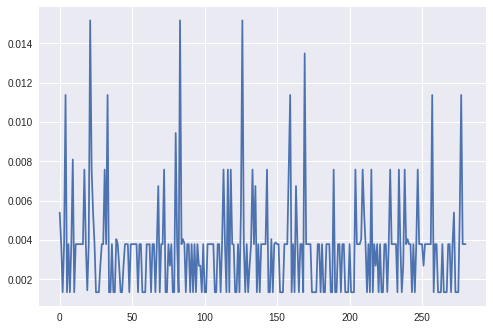

In [0]:
preds = model.predict(keys_encoded, verbose=0)[0]
plt.plot(preds)

In [0]:
ix=np.argsort(preds)
print(index_to_package[ix[-1]])
print(index_to_package[ix[-2]])
print(index_to_package[ix[-3]])
print(index_to_package[ix[-4]])

gulp
babel-loader
babel-preset-es2015
mocha


In [0]:
packages_dic[repo]

[{'browserify': '^10.0.0',
  'istanbul-harmony': '0',
  'mocha': '^2.0.0',
  'mz': '^1.0.2'}]